# Red Neuronal

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("pitagoras.xlsx")

In [3]:

df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
df.index = df['date']
df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['date', 'views']])
#

data.index = data.date
data.drop('date', axis=1, inplace=True)
data.head()

,views
date,
2015-07-01,4701
2015-07-02,6333
2015-07-03,3625
2015-07-04,2133
2015-07-05,2530


Actualmente solo tenemos una columna (el número de visitas a la página del teórema de Pitagoras de Wikipedia). Para entrenar la red neuronal, se decide usar los 24 valores pasados como entradas adicionales. Para esto se construye la siguiente función.

In [6]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
            
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [7]:
list_of_attributes = ['views']

list_of_prev_t_instants = []
for i in range(1,25):
    list_of_prev_t_instants.append(i)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [8]:
df_new = create_regressor_attributes(data, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,views,views_(t-1),views_(t-2),views_(t-3),views_(t-4),views_(t-5),views_(t-6),views_(t-7),views_(t-8),views_(t-9),views_(t-10),views_(t-11),views_(t-12),views_(t-13),views_(t-14),views_(t-15),views_(t-16),views_(t-17),views_(t-18),views_(t-19),views_(t-20),views_(t-21),views_(t-22),views_(t-23),views_(t-24)
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-25,1578,2353,3003,3460,3504,3149,1886,1891,2775,3470,3822,3656,3415,2495,2283,3308,4048,4617,4507,3866,2530,2133,3625,6333,4701
2015-07-26,1960,1578,2353,3003,3460,3504,3149,1886,1891,2775,3470,3822,3656,3415,2495,2283,3308,4048,4617,4507,3866,2530,2133,3625,6333
2015-07-27,2815,1960,1578,2353,3003,3460,3504,3149,1886,1891,2775,3470,3822,3656,3415,2495,2283,3308,4048,4617,4507,3866,2530,2133,3625
2015-07-28,3220,2815,1960,1578,2353,3003,3460,3504,3149,1886,1891,2775,3470,3822,3656,3415,2495,2283,3308,4048,4617,4507,3866,2530,2133
2015-07-29,2890,3220,2815,1960,1578,2353,3003,3460,3504,3149,1886,1891,2775,3470,3822,3656,3415,2495,2283,3308,4048,4617,4507,3866,2530


Tras obtener los retardos se dividen los datos entre los datos de entrenamiento, de validación y de prueba.

In [130]:
test_set_size = 0.094
valid_set_size= 0.094

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size)))+1 : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size)))+1 ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size)))+1 ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size)))+1 : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (640, 24) (640,)
Shape of validation inputs, validation target: (66, 24) (66,)
Shape of test inputs, test target: (73, 24) (73,)


Se normalizan los datos en el rango (0.01, 0.99) como ultimo paso antes de crear la red neuronal.

In [85]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

Se decide usar funciones de activación lineales porque al tenerse tan pocos datos otras funciones de activación exponen al modelo a un sobre-ajuste.

In [109]:
input_layer = Input(shape=(24), dtype='float32')
dense1 = Dense(4, activation='linear')(input_layer)
#dropout_layer1 = Dropout(0.1)(dense1)
#dense2 = Dense(2, activation='relu')(dropout_layer1)
#dropout_layer2 = Dropout(0.1)(dense2)
#output_layer = Dense(1, activation='relu')(dropout_layer1)
output_layer = Dense(1, activation='linear')(dense1)

In [110]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 24)]              0         
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 100       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 5         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [111]:
tf.random.set_seed(100)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
history = model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=20, epochs=50, validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/50
32/32 [==============================] - 0s 5ms/step - loss: 0.2732 - val_loss: 0.2536
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.1490
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.1291
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.1095
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0931
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0768
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0679
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0561
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0488
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0183 - val_loss: 0.0419
Epoch 11/50
32/32 [

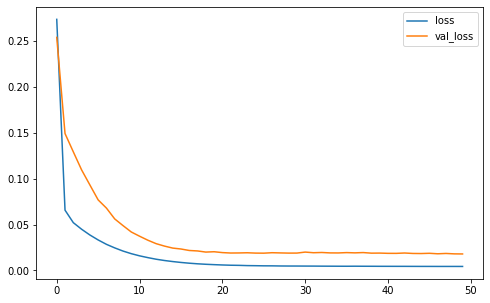

In [112]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [113]:
y_pred = model.predict(X_test_scaled)

In [114]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

Se usa el puntaje $R^2$ para determinar la calidad del modelo y se evaluan las predicciones

In [131]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R^2:', round(score,4))

R^2: 0.8393


In [116]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted'])

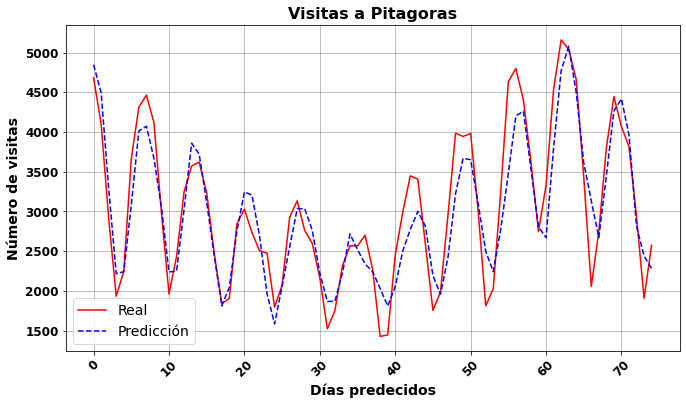

In [122]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Real','Predicción'], loc='best', prop={'size': 14})
plt.title('Visitas a Pitagoras', weight='bold', fontsize=16)
plt.ylabel('Número de visitas', weight='bold', fontsize=14)
plt.xlabel('Días predecidos', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'gray', linewidth='0.5')
plt.show()

Finalmente obteniendo un muy buen ajuste en los datos de prueba, por lo que se considera un buen modelo al momento de realizar la predicción.

In [119]:
mse_test=model.evaluate(X_valid_scaled, y_valid_scaled)
print(mse_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.0180
0.01796874590218067
